In [5]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# 1. ER phase transitions

## a) ER graph component sizes

In [11]:
def analyze_er_graph_components(n, p_range, graphs_per_p=20):
    means, sds = [], []
    for p in p_range:
        print('Analyzing ER graphs for p={}'.format(p))
        comp_sizes = []
        for i in range(graphs_per_p):
            G = nx.generators.fast_gnp_random_graph(n, p, seed=i)
            comp_sizes.append(max([len(comp) for comp in nx.connected_components(G)]))
        means.append(np.mean(comp_sizes))
        sds.append(np.std(comp_sizes))

    return np.array(means), np.array(sds)


In [12]:
n = 5000
p_range = np.logspace(-5, -2, num=20)
means, sds = analyze_er_graph_components(n, p_range)

Analyzing ER graphs for p=1e-05
Analyzing ER graphs for p=1.438449888287663e-05
Analyzing ER graphs for p=2.06913808111479e-05
Analyzing ER graphs for p=2.9763514416313192e-05
Analyzing ER graphs for p=4.281332398719396e-05
Analyzing ER graphs for p=6.158482110660267e-05
Analyzing ER graphs for p=8.858667904100833e-05
Analyzing ER graphs for p=0.00012742749857031334
Analyzing ER graphs for p=0.00018329807108324357
Analyzing ER graphs for p=0.00026366508987303583
Analyzing ER graphs for p=0.000379269019073225
Analyzing ER graphs for p=0.0005455594781168515
Analyzing ER graphs for p=0.0007847599703514606
Analyzing ER graphs for p=0.0011288378916846883
Analyzing ER graphs for p=0.001623776739188721
Analyzing ER graphs for p=0.002335721469090121
Analyzing ER graphs for p=0.003359818286283781
Analyzing ER graphs for p=0.004832930238571752
Analyzing ER graphs for p=0.0069519279617756054
Analyzing ER graphs for p=0.01


In [13]:
def plot_with_sds(x, y, y_sds, n=5_000):
    plt.plot(x, y)
    plt.plot(x, y - y_sds, c='green', linestyle='dashed')
    plt.plot(x, y + y_sds, c='red', linestyle='dashed')

    # plot vertical lines at 1 / n and ln(n) / n
    plt.vlines(1 / n, 0, 100, linestyle='dotted', colors='gray')
    plt.vlines(np.log(n) / n, 0, 4900, linestyle='dotted', colors='black')

    plt.yscale('log')
    plt.xscale('log')
    plt.title('Mean largest component size for ER graphs')
    plt.xlabel('p (log scale)')
    plt.ylabel('Mean component size (log scale)')
    plt.legend(['Mean', 'Mean + SD', 'MEan - SD', '1 / n', 'ln(n) / n'])

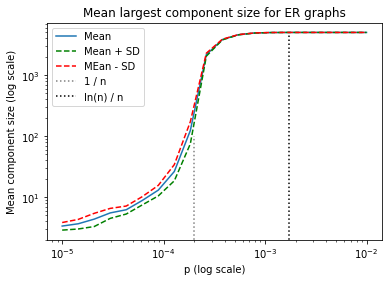

In [14]:
plot_with_sds(p_range, means, sds)

## b) Interesting values of p

From class, we have that when p = lambda / n, lambda > 1 makes the largest component size converge to n, while lambda < 1 makes it converge to ln(n). Here, lambda = 1 represents a point at which the largest component size is transitioning rapidly, as it has the graph's peak slope. Also, I notice that as lambda shrinks less than 1, the size remains low (near ln(n) ~= 8), while as lambda grows above 1, the size approaches n.

Also, we have that when p = lambda * ln(n) / n, lambda < 1 makes the graph's probability of being connected converge to 0, while lambda > 1 makes it converge to 1. Here, to the left of ln(n) / n (i.e. lambda > 1), the mean component size has not yet converged to n, but to the right, the mean is equal to n and the standard deviation is 0, meaning that, as expected, all sampled graphs converge to being connected. 

# 2. Fitting power-law exponents

## b) Pareto sampling

In [15]:
def sample_pareto(alpha=1, x_0=1, size=100_000):
    pareto_func = np.vectorize(lambda u:  x_0 / u**(1 / alpha))
    u_samples = np.random.sample(size=size)
    return pareto_func(u_samples)

def compute_pdf(samples):
    samples_ints = np.round(samples, decimals=0)
    samples_int_counts = Counter(samples_ints)
    x = np.array(sorted(samples_int_counts.keys()))
    px_x = np.array([samples_int_counts[k] for k in x])
    px_x = px_x / px_x.sum()
    return x, px_x

def compute_ccdf(x, px_x):
    s = 0
    fbarx_x = np.zeros(px_x.shape)
    for i in range(len(x) - 1, -1, -1):
        s += px_x[i]
        fbarx_x[i] = s
    
    return x, fbarx_x

def plot_observations(x, y, alpha=1):
    plt.scatter(x, y, s=5)
    plt.xscale('log')
    plt.yscale('log')
    y_expected = 1 / x ** (alpha + 1)
    plt.plot(x[y_expected >= 1e-5], y_expected[y_expected >= 1e-5], c='green')
    plt.title('Sampled and actual PDFs for Pareto distribution')
    plt.legend(['Sampled', 'Actual'])
    plt.xlabel('x (log scale)')
    plt.ylabel('p(X = x) (log scale)')

In [16]:
pareto = sample_pareto()
x, px_x = compute_pdf(pareto)

In [17]:
x, fbarx_x = compute_ccdf(x, px_x)

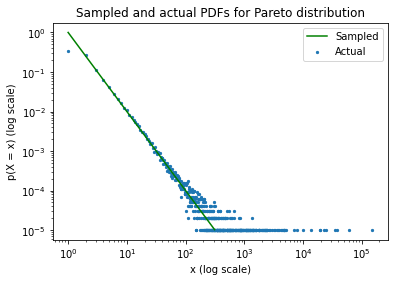

In [18]:
plot_observations(x, px_x)

## d) Estimating alpha

In [7]:
def estimate_alpha_pdf_ls(samples):
    x, p_x = compute_pdf(samples)

    x_log = np.log(x.reshape((x.shape[0], 1)))
    y_log = np.log(p_x)
    
    alpha_pred = -np.linalg.lstsq(x_log, y_log, rcond=None)[0] - 1
    return alpha_pred

def estimate_alpha_ccdf_ls(samples):
    x, px_x = compute_pdf(samples)
    x, fbarx_x = compute_ccdf(x, px_x)

    x_log = np.log(x.reshape((x.shape[0], 1)))
    y_log = np.log(fbarx_x)
    
    # integrating the PDF gives line with slope -alpha
    alpha_pred = -np.linalg.lstsq(x_log, y_log, rcond=None)[0]
    
    return alpha_pred

def estimate_alpha_mle(samples, x_0=1):
    n = len(samples)
    
    # from c), MLE is alpha = n / (sum_i(log(x_i)) - (n * log(x_0)))
    return n / (np.log(samples).sum() - (n * np.log(x_0)))

def eval_alpha_estimate(estimate_alpha, name, samples=100):
    preds = []
    for _ in range(samples):
        samples = sample_pareto()
        preds.append(estimate_alpha(samples))
    m, sd = np.mean(preds), np.std(preds)
    print('{}:'.format(name))
    print('Mean: {}, SD: {}'.format(m, sd))


In [8]:
eval_alpha_estimate(estimate_alpha_pdf_ls, 'Least-squares on PDF');

Least-squares on PDF:
Mean: 0.7535055686849037, SD: 0.01445416636769601


In [9]:
eval_alpha_estimate(estimate_alpha_ccdf_ls, 'Least-squares on CCDF');

Least-squares on CCDF:
Mean: 0.9985720588961311, SD: 0.010272736553571053


In [10]:
eval_alpha_estimate(estimate_alpha_mle, 'Log-likelihood maximization');

Log-likelihood maximization:
Mean: 1.0003310052420762, SD: 0.0032189410484160037


Least-squares regression on the PDF gives a very poor result (25% too small), while least-squares on the CCDF and the log-likelihood MLE both give results very close to the true value. The MLE is closer to the true value than CCDF least-squares by one order of magnitude, and has a smaller standard deviation, so I'd say that the MLE gives the best estimate. 